# Depression and Anxiety base classification

Based on the study by [Cavanagh et al. (2019)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6515849/)

Import packages

In [37]:
import io
import mne
import copy
import glob
import array
import matplotlib
import numpy as np
import pandas as pd
import sklearn.metrics
import seaborn as sns
import scipy.io as sio
import plotly.express as px
import matplotlib.pyplot as plt


from itertools import chain
from sklearn.svm import SVC
from scipy.io import loadmat
from sklearn import set_config

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import permutation_test_score
from sklearn.linear_model import LinearRegression


import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, RepeatedStratifiedKFold
from sklearn.utils import resample

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer

from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA, FastICA

from scipy import stats

# parameters for plotting
plt.rcParams["figure.figsize"] = (10,7)

import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

Constatnts

In [15]:
random_state = 42

## Load questionnarie data

In [28]:
data = pd.read_csv('data\data.csv')

In [17]:
data['disorder'] = 0
for i in range(len(data)):
    if data['BDI'][i] != '#NULL!' and data['BDI'][i] >= 13:
        data['disorder'][i] = 1
    else:
        data['disorder'][i] = 0

C:\Users\NASA\AppData\Local\Temp\ipykernel_3936\1494664159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['disorder'][i] = 0
C:\Users\NASA\AppData\Local\Temp\ipykernel_3936\1494664159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['disorder'][i] = 0
C:\Users\NASA\AppData\Local\Temp\ipykernel_3936\1494664159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['disorder'][i] = 0
C:\Users\NASA\AppData\Local\Temp\i

In [18]:
data

,id,SCID,SCID_note,HamD,sex,age,BDI,BDI_cog,BDI_aff,BDI_som,...,loconf_rt,pos_rt,neg_rt,hiconf_pos_rt,loconf_pos_rt,hiconf_neg_rt,loconf_neg_rt,TST_aG,TST_aL,disorder
0,507,99.0,NaN,#NULL!,1,19,0.0,0.00,0.00,0.00,...,753.41,722.02,828.73,728.21,721.10,905.28,785.73,0.12,0.00,0
1,508,99.0,NaN,#NULL!,1,18,4.0,0.00,0.67,0.17,...,932.63,772.36,986.75,771.20,896.43,1202.03,968.84,0.28,0.93,0
2,509,99.0,NaN,#NULL!,1,18,7.0,0.17,0.00,0.67,...,739.20,739.28,830.53,794.16,736.67,830.53,741.74,0.07,0.05,0
3,510,99.0,NaN,#NULL!,1,19,1.0,0.00,0.00,0.17,...,1239.09,1231.04,1500.53,1113.41,1123.20,1035.47,1354.97,0.37,0.63,0
4,511,99.0,NaN,#NULL!,2,22,1.0,0.00,0.00,0.17,...,1527.80,1908.43,1305.88,1885.73,1731.80,1297.05,1323.80,0.95,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,624,1.0,NaN,21.00,1,20,23.0,1.33,1.00,0.67,...,696.15,685.56,799.69,764.35,645.86,843.43,746.44,0.65,0.81,1
117,625,2.0,subsyndromal current,4.00,1,19,16.0,0.67,1.00,0.83,...,1149.39,1130.01,1153.62,1159.48,1116.37,1139.42,1182.42,0.69,1.00,1
118,626,1.0,NaN,10.00,1,18,14.0,0.33,1.00,0.83,...,1805.77,1878.83,1732.71,1071.52,1878.83,1780.84,1732.71,0.70,0.38,1
119,627,2.0,NaN,3.00,2,19,30.0,1.00,1.33,2.17,...,2131.00,2065.05,2270.19,2167.89,1941.75,2261.39,2320.25,0.10,0.61,1


In [42]:
ids = data['id'][:].astype(int)

## Load EEG data

In [19]:
ctrl_dep = [data.iloc[part] for part in range(len(data)) if data['BDI'][part] <= 13 and data['TAI'][part] > 28]
ctrl_dep = pd.DataFrame(ctrl_dep)
len(ctrl_dep)

47

In [48]:
dep = [data.iloc[part] for part in range(len(data)) if data['BDI'][part] > 13.0 and data['TAI'][part] > 28]
dep = pd.DataFrame(dep)
len(dep)

45

In [9]:
anx = [data.iloc[part] for part in range(len(data)) if (data['TAI'][part] > 30) and (data['BDI'][part] < 13)]
anx = pd.DataFrame(anx)
len(anx)

35

In [22]:
ctrl_anx = [data.iloc[part] for part in range(len(data)) if data['TAI'][part] < 29 and data['BDI'][part] <= 13] # tai < 30
ctrl_anx = pd.DataFrame(ctrl_anx)
len(ctrl_anx)

29

In [23]:
anx = [data.iloc[part] for part in range(len(data)) if (data['TAI'][part] > 31) and (data['BDI'][part] < 7)]
anx = pd.DataFrame(anx)
len(abnx)

31

In [24]:
anx = anx[(anx['id'] != 599) & (anx['id'] != 600)]
len(anx)

29

In [25]:
ctrl_anx = [data.iloc[part] for part in range(len(data)) if (data['TAI'][part] < 29) and (data['BDI'][part] < 7)]
ctrl_anx = pd.DataFrame(ctrl_anx)
len(ctrl_anx)

29

In [73]:
def read_epochs(arr, group):
    for i in range(len(group)):
        fname = str(int(group.values[i, 0])) + "-epo.fif"
        print("\n\n" + fname)
        # these records don't exist
        if fname == "599-epo.fif" or fname == "600-epo.fif":
            continue
        arr.append(mne.read_epochs('data/' + fname))

In [29]:
%%capture

dep_epochs = []
read_epochs(dep_epochs, dep)

In [30]:
len(dep_epochs)

45

In [31]:
%%capture

ctrl_dep_epochs = []
read_epochs(ctrl_dep_epochs, ctrl_dep)

In [32]:
len(ctrl_dep_epochs)

45

In [33]:
%%capture

anx_epochs = []
read_epochs(anx_epochs, anx)

In [34]:
len(anx_epochs)

29

In [35]:
%%capture

ctrl_anx_epochs = []
read_epochs(ctrl_anx_epochs, ctrl_anx)

In [36]:
len(ctrl_anx_epochs)

29

## Regression

In [67]:
#load whole data
all_data = [data.iloc[part] for part in range(len(data))]
all_data = pd.DataFrame(all)
all

,id,SCID,SCID_note,HamD,sex,age,BDI,BDI_cog,BDI_aff,BDI_som,...,hiconf_rt,loconf_rt,pos_rt,neg_rt,hiconf_pos_rt,loconf_pos_rt,hiconf_neg_rt,loconf_neg_rt,TST_aG,TST_aL
0,507,99.0,NaN,#NULL!,1,19,0.0,0.00,0.00,0.00,...,816.75,753.41,722.02,828.73,728.21,721.10,905.28,785.73,0.12,0.00
1,508,99.0,NaN,#NULL!,1,18,4.0,0.00,0.67,0.17,...,986.62,932.63,772.36,986.75,771.20,896.43,1202.03,968.84,0.28,0.93
2,509,99.0,NaN,#NULL!,1,18,7.0,0.17,0.00,0.67,...,812.35,739.20,739.28,830.53,794.16,736.67,830.53,741.74,0.07,0.05
3,510,99.0,NaN,#NULL!,1,19,1.0,0.00,0.00,0.17,...,1074.44,1239.09,1231.04,1500.53,1113.41,1123.20,1035.47,1354.97,0.37,0.63
4,511,99.0,NaN,#NULL!,2,22,1.0,0.00,0.00,0.17,...,1591.39,1527.80,1908.43,1305.88,1885.73,1731.80,1297.05,1323.80,0.95,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,624,1.0,NaN,21.00,1,20,23.0,1.33,1.00,0.67,...,803.89,696.15,685.56,799.69,764.35,645.86,843.43,746.44,0.65,0.81
117,625,2.0,subsyndromal current,4.00,1,19,16.0,0.67,1.00,0.83,...,1149.45,1149.39,1130.01,1153.62,1159.48,1116.37,1139.42,1182.42,0.69,1.00
118,626,1.0,NaN,10.00,1,18,14.0,0.33,1.00,0.83,...,1426.18,1805.77,1878.83,1732.71,1071.52,1878.83,1780.84,1732.71,0.70,0.38
119,627,2.0,NaN,3.00,2,19,30.0,1.00,1.33,2.17,...,2214.64,2131.00,2065.05,2270.19,2167.89,1941.75,2261.39,2320.25,0.10,0.61


In [68]:
STAI = all_data['TAI']
STAI

0      23.0
1      47.0
2      44.0
3      27.0
4      23.0
       ... 
116    60.0
117    60.0
118    41.0
119    47.0
120    56.0
Name: TAI, Length: 121, dtype: float64

In [69]:
BDI = all_data['BDI_cog'] + all_data['BDI_aff']
BDI

0      0.00
1      0.67
2      0.17
3      0.00
4      0.00
       ... 
116    2.33
117    1.67
118    1.33
119    2.33
120    1.17
Length: 121, dtype: float64

In [ ]:
%%capture
all_epochs = []
read_epochs(all_epochs, all_data)

In [ ]:
tmin = 0.25
tmax = 0.35
picks = ["FCz"]

In [ ]:
def get_rewps(epochs):
  rewps = []
  for i in range(len(epochs)):
    avg = epochs[i]['good'].average().get_data(picks=picks, tmin=tmin, tmax=tmax)
    rewps.append(avg.mean())
  return rewps

In [ ]:
all_rewps = []
dep_rewps = get_rewps(all_data)

In [ ]:
tmin = 0.25
tmax = 0.37
picks = ["FCz"]

In [ ]:
def get_fnrs(epochs):
  frns = []
  for i in range(len(epochs)):
    diff = epochs[i]['bad'].average().get_data(picks=picks, tmin=tmin, tmax=tmax).max() - epochs[i]['bad'].average().get_data(picks=picks, tmin=tmin, tmax=tmax).min()
    frns.append(diff)
  return frns

In [ ]:
all_frns = []
dep_frns = get_fnrs(all_data)

In [ ]:
model = LinearRegression()

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

scores = cross_val_score(model, all_rewps, y, cv=kf, scoring='r2')


### Depression vs Control

#### RewP

In [70]:
tmin = 0.25
tmax = 0.35
picks = ["FCz"]

In [71]:
def get_rewps(epochs):
  rewps = []
  for i in range(len(epochs)):
    avg = epochs[i]['good'].average().get_data(picks=picks, tmin=tmin, tmax=tmax)
    rewps.append(avg.mean())
  return rewps

In [72]:
dep_data = []
ctrl_data = []
dep_data = get_rewps(all_data)
ctrl_data = get_rewps(all_data)

KeyError: 0

#### FRN

In [64]:
tmin = 0.25
tmax = 0.37
picks = ["FCz"]

In [65]:
def get_fnrs(epochs):
  frns = []
  for i in range(len(epochs)):
    diff = epochs[i]['bad'].average().get_data(picks=picks, tmin=tmin, tmax=tmax).max() - epochs[i]['bad'].average().get_data(picks=picks, tmin=tmin, tmax=tmax).min()
    frns.append(diff)
  return frns

In [66]:
dep_data = []
ctrl_data = []
dep_data = get_fnrs(dep_epochs)
ctrl_data = get_fnrs(ctrl_dep_epochs)

### Anxiety vs Control

#### RewP

In [83]:
tmin = 0.25
tmax = 0.35
picks = ["FCz"]

In [84]:
anx_data = []
ctrl_data = []
anx_data = get_rewps(anx_epochs)
ctrl_data = get_rewps(ctrl_anx_epochs)

In [85]:
X = pd.DataFrame(pd.concat([pd.DataFrame(anx_data), pd.DataFrame(ctrl_data)]))
y = np.array(len(anx_data) * [1] +  len(ctrl_data) * [0])
len(y)

66

In [86]:
print(f"ANX len: {len(anx_data)}\nCTR len: {len(ctrl_data)}")

ANX len: 33
CTR len: 33


In [87]:
%%capture

results_anx_rewp_df = pd.DataFrame()

vec = Vectorizer()
# cv = ShuffleSplit(3, test_size=0.3, random_state=random_state)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=random_state)

for (estimator, params) in estimators:
    print(f"Rating {estimator} \n")
    pipeline_name = "RewP_Anxiety_" + estimator[0]
    
      # create pipeline from base steps list and estimator
    pipe = Pipeline([estimator])

      # enter to grid search
    grid_result = evaluate_GS_model(
        pipe,
        X,
        y,
        params,
        pipeline_name=pipeline_name,
        predict_test = True,
        predict_train = True,
    )
    print(grid_result)

    results_anx_rewp_df = pd.concat([results_anx_rewp_df, grid_result])

In [88]:
results_anx_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_precision,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy
0,lg,RewP_Anxiety_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,0.500000,0.00000,0.500000
0,svc,RewP_Anxiety_svc,0.681818,0.542857,(SVC(C=1000)),"{'svc__C': 1000, 'svc__kernel': 'rbf'}",0.319680,0.653061,0.785714,0.285714,0.452381,0.761905,0.517576,0.587755,0.62381,0.542857
0,lda,RewP_Anxiety_lda,0.575758,0.583333,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.128871,0.387755,0.809524,0.476190,0.642857,0.642857,0.625000,0.591837,0.52381,0.583333


In [89]:
results_anx_rewp_df.to_pickle("data/anxiety_rewp_results_3_21_03_11-30.pkl")

#### FRN

In [90]:
tmin = 0.25
tmax = 0.37
picks = ["FCz"]

In [91]:
anx_data = []
ctrl_data = []
anx_data = get_fnrs(anx_epochs)
ctrl_data = get_fnrs(ctrl_anx_epochs)

In [92]:
X = pd.DataFrame(pd.concat([pd.DataFrame(anx_data), pd.DataFrame(ctrl_data)]))
y = np.array(len(anx_data) * [1] +  len(ctrl_data) * [0])

In [93]:
print(f"ANX len: {len(anx_data)}\nCTR len: {len(ctrl_data)}")

ANX len: 33
CTR len: 33


In [94]:
%%capture

results_anx_frn_df = pd.DataFrame()

vec = Vectorizer()
# cv = ShuffleSplit(3, test_size=0.3, random_state=random_state)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=random_state)

for (estimator, params) in estimators:
    print(f"Rating {estimator} \n")
    pipeline_name = "FRN_Anxiety_" + estimator[0]
    
      # create pipeline from base steps list and estimator
    pipe = Pipeline([estimator])

      # enter to grid search
    grid_result = evaluate_GS_model(
        pipe,
        X,
        y,
        params,
        pipeline_name=pipeline_name,
        predict_test = True,
        predict_train = True,
    )
    print(grid_result)

    results_anx_frn_df = pd.concat([results_anx_frn_df, grid_result])

In [95]:
results_anx_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_precision,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy
0,lg,FRN_Anxiety_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,0.500000,0.000000,0.500000
0,svc,FRN_Anxiety_svc,0.651515,0.542857,(SVC(C=10)),"{'svc__C': 10, 'svc__kernel': 'rbf'}",0.227772,0.204082,0.690476,0.690476,0.547619,0.571429,0.543810,0.540816,0.509524,0.542857
0,lda,FRN_Anxiety_lda,0.469697,0.457143,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.742258,0.775510,0.452381,0.476190,0.309524,0.619048,0.488333,0.526531,0.361905,0.457143


In [96]:
results_anx_frn_df.to_pickle("data/anxiety_frn_results_3_21_03_11-30.pkl")

In [97]:
# # plot CSP patterns estimated on full data for visualization
# # epochs_train = anx_epochs[0]['bad'].copy().crop(tmin=tmin, tmax=tmax).pick_types(eeg=True)
# epochs_train = anx_epochs[0]['bad'].copy().crop(tmin=tmin, tmax=tmax).pick_channels(['P1', 'P2', 'P4', 'P3', 'CP3', 'CP4', 'CP1', 'CP2', 'Pz', 'CPz',])

# epochs_train.info

# csp.fit_transform(evoked_data, y)

# fig = csp.plot_patterns(epochs_train.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

## Test statistical differences between models

In [98]:
def paired_ttest_nandeu(
    estimator1,
    estimator2,
    X_1,
    X_2,
    y,
    scoring='accuracy',
    random_state=0  
):
    """Computes paired-ttest using Nadeau and Bengio's approach.

    Parameters
    ----------
    estimator1 : estimator object implementing 'fit'
        The object to use to fit the data.
    estimator2 :  estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like of shape at least 2D
        The data to fit.
    y : array-like of shape (n_samples,)
        The target variable to try to predict
    random_state: int


    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_value : float
        Variance-corrected p-value.
    """

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

    cv_scores_1 = cross_val_score(estimator1, X_1, y, cv=cv, scoring=scoring)
    cv_scores_2 = cross_val_score(estimator2, X_2, y, cv=cv, scoring=scoring)

    differences = cv_scores_1 - cv_scores_2

    n = differences.shape[0]  # number of test sets
    df = n - 1
    n_train = len(list(cv.split(X_1, y))[0][0])
    n_test = len(list(cv.split(X_1, y))[0][1])

    t_stat, p_value = compute_corrected_ttest(differences, df, n_train, n_test)

    return t_stat, p_value


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * ((1 / kr) + (n_test / n_train))
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = stats.t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [99]:
results_dep_rewp_df = pd.read_pickle("data/depression_rewp_results_3_02_03_24-00.pkl")
results_dep_frn_df = pd.read_pickle("data/depression_frn_results_3_02_03_24-00.pkl")
results_anx_rewp_df = pd.read_pickle("data/anxiety_rewp_results_3_21_03_11-30.pkl")
results_anx_frn_df = pd.read_pickle("data/anxiety_frn_results_3_21_03_11-30.pkl")

### Depression RewP vs FRN

In [100]:
y = np.array(len(dep_epochs) * [1] +  len(ctrl_dep_epochs) * [0])

In [101]:
tmin = 0.25
tmax = 0.35
picks = ["FCz"]

In [102]:
dep_rewp_data = []
ctrl_rewp_data = []
dep_rewp_data = get_rewps(dep_epochs)
ctrl_rewp_data = get_rewps(ctrl_dep_epochs)

In [103]:
#X_rewp = np.array(dep_rewp_data + ctrl_rewp_data)
X_rewp = pd.DataFrame(pd.concat([pd.DataFrame(dep_rewp_data), pd.DataFrame(ctrl_rewp_data)]))

In [104]:
tmin = 0.25
tmax = 0.37
picks = ["FCz"]

In [105]:
dep_frn_data = []
ctrl_frn_data = []
dep_frn_data = get_fnrs(dep_epochs)
ctrl_frn_data = get_fnrs(ctrl_dep_epochs)

In [106]:
#X_frn = np.array(dep_frn_data + ctrl_frn_data)
X_frn = pd.DataFrame(pd.concat([pd.DataFrame(dep_frn_data), pd.DataFrame(ctrl_frn_data)]))

#### Plot differences between all Depression Models
To see which RewP and FRN models are the best

In [107]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_results_df = pd.DataFrame()

for i in range(0,len(results_dep_rewp_df)):
    cv_scores_rewp = cross_val_score(results_dep_rewp_df.iloc[i].best_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
    cv_scores_frn = cross_val_score(results_dep_frn_df.iloc[i].best_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')
    
    cv_results_df["RewP_" + str(i)] = cv_scores_rewp
    cv_results_df["FRN_" + str(i)] = cv_scores_frn

In [108]:
cv_results_df

,RewP_0,FRN_0,RewP_1,FRN_1,RewP_2,FRN_2
0,0.5,0.5,0.5,0.775,0.500,0.575
1,0.5,0.5,0.5,0.375,0.500,0.575
2,0.5,0.5,0.5,0.475,0.350,0.550
3,0.5,0.5,0.5,0.350,0.500,0.225
4,0.5,0.5,0.5,0.575,0.500,0.500
...,...,...,...,...,...,...
95,0.5,0.5,0.5,0.475,0.325,0.225
96,0.5,0.5,0.5,0.350,0.350,0.475
97,0.5,0.5,0.5,0.575,0.350,0.375
98,0.5,0.5,0.5,0.625,0.325,0.100


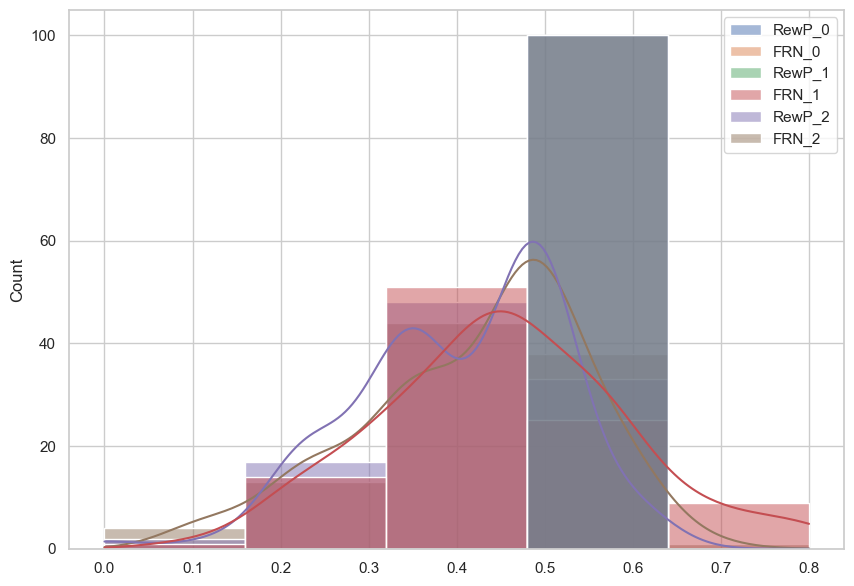

In [109]:
fig = sns.histplot(data=cv_results_df, bins=5, kde=True)

#### Test differences between the best models

Chose the best models

In [110]:
results_dep_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_precision,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy
0,lg,RewP_Depression_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,0.500000,0.000000,0.500000
0,svc,RewP_Depression_svc,0.566667,0.555556,(SVC(C=0.0001)),"{'svc__C': 0.0001, 'svc__kernel': 'rbf'}",0.242757,0.567901,0.703704,0.432099,0.641975,0.567901,0.524359,0.582716,0.533333,0.555556
0,lda,RewP_Depression_lda,0.533333,0.422222,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.886114,0.432099,0.518519,0.345679,0.469136,0.283951,0.428687,0.409877,0.466667,0.422222


In [111]:
results_dep_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_precision,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy
0,lg,FRN_Depression_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.00000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,0.500000,0.000000,0.500000
0,svc,FRN_Depression_svc,0.544444,0.533333,(SVC(C=1000)),"{'svc__C': 1000, 'svc__kernel': 'rbf'}",0.35964,0.617284,0.320988,0.456790,0.481481,0.358025,0.586508,0.446914,0.444444,0.533333
0,lda,FRN_Depression_lda,0.466667,0.444444,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.81019,0.641975,0.246914,0.481481,0.481481,0.283951,0.421861,0.427160,0.422222,0.444444


In [112]:
dep_rewp_model = results_dep_rewp_df.iloc[1].best_model
dep_rewp_model

Pipeline(steps=[('svc', SVC(C=0.0001))])

In [114]:
dep_frn_model = results_dep_frn_df.iloc[0].best_model
dep_frn_model

Pipeline(steps=[('lg', LogisticRegression(penalty='l1', solver='liblinear'))])

- Balanced Accuracy

In [115]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='balanced_accuracy'
)

In [116]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: nan
p value: nan


- Roc AUC

In [117]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='roc_auc'
)

In [118]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.443
p value: 0.329


- precision

In [119]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='precision'
)

In [120]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 2.859
p value: 0.003


- recall

In [121]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='recall'
)

In [122]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 2.859
p value: 0.003


- F1

In [123]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='f1'
)

In [124]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 2.859
p value: 0.003


Visualize difference between FRN and RewP models

In [125]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(dep_rewp_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
cv_scores_2 = cross_val_score(dep_frn_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')

In [126]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

In [127]:
cv_results_df

,RewP,FRN
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
...,...,...
95,0.5,0.5
96,0.5,0.5
97,0.5,0.5
98,0.5,0.5


LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

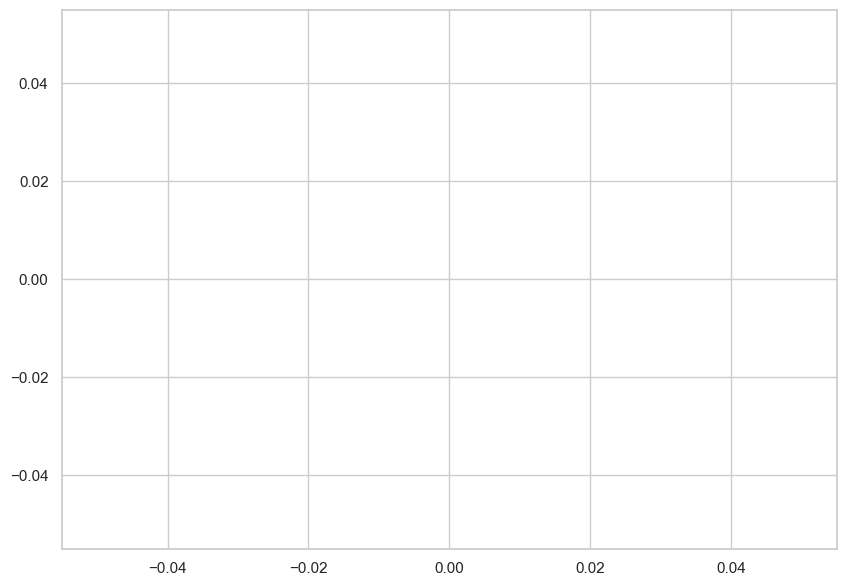

In [128]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

C:\Users\rafal\AppData\Local\Temp\ipykernel_14932\3509821564.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  fig = sns.kdeplot(data=cv_results_df, fill=True)


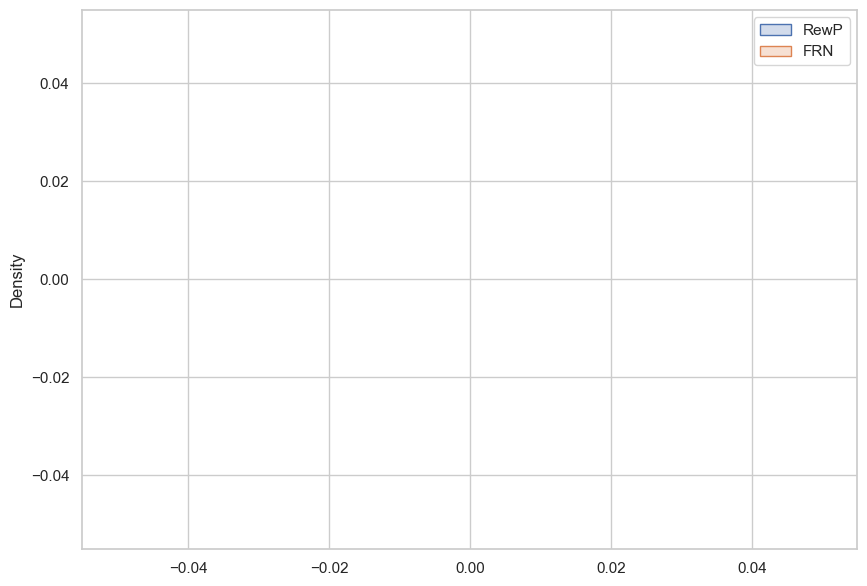

In [129]:
fig = sns.kdeplot(data=cv_results_df, fill=True)

In [130]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(dep_rewp_model, X_rewp, y, cv=cv, scoring='roc_auc')
cv_scores_2 = cross_val_score(dep_frn_model, X_frn, y, cv=cv,  scoring='roc_auc')

In [131]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

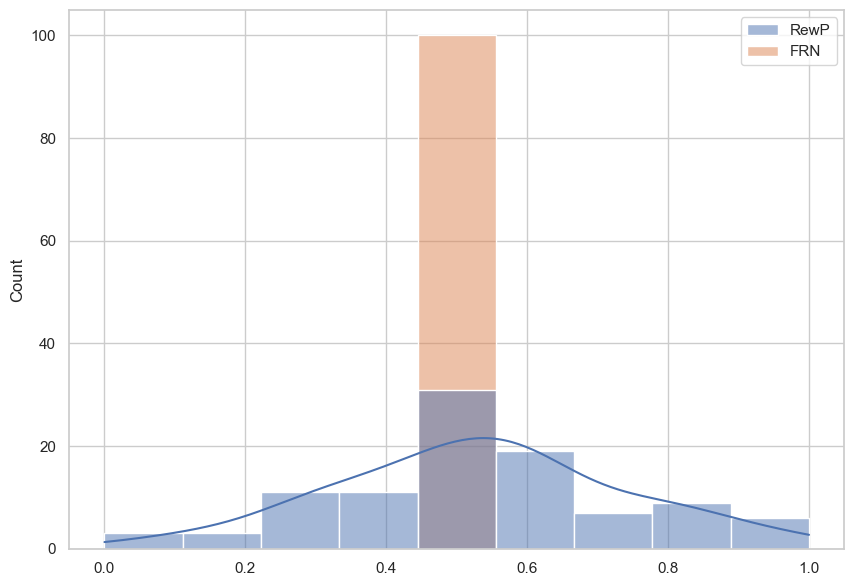

In [132]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

### Anxiety RewP vs FRN

In [135]:
y = np.array(len(anx_epochs) * [1] +  len(ctrl_anx_epochs) * [0])

In [136]:
tmin = 0.25
tmax = 0.35
picks = ["FCz"]

In [137]:
anx_rewp_data = []
ctrl_rewp_data = []
anx_rewp_data = get_rewps(anx_epochs)
ctrl_rewp_data = get_rewps(ctrl_anx_epochs)

In [138]:
X_rewp = pd.DataFrame(pd.concat([pd.DataFrame(anx_rewp_data), pd.DataFrame(ctrl_rewp_data)]))
#X_rewp = np.array(anx_rewp_data + ctrl_rewp_data)

In [139]:
tmin = 0.25
tmax = 0.37
picks = ["FCz"]

In [140]:
anx_frn_data = []
ctrl_frn_data = []
anx_frn_data = get_fnrs(anx_epochs)
ctrl_frn_data = get_fnrs(ctrl_anx_epochs)

In [141]:
X_frn = pd.DataFrame(pd.concat([pd.DataFrame(anx_frn_data), pd.DataFrame(ctrl_frn_data)]))
#X_frn = np.array(anx_frn_data + ctrl_frn_data)

#### Plot differences between all Anxiety Models
To see which RewP and FRN models are the best

In [142]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_results_df = pd.DataFrame()

for i in range(0,len(results_anx_rewp_df)):
    cv_scores_rewp = cross_val_score(results_anx_rewp_df.iloc[i].best_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
    cv_scores_frn = cross_val_score(results_anx_frn_df.iloc[i].best_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')
    
    cv_results_df["RewP_" + str(i)] = cv_scores_rewp
    cv_results_df["FRN_" + str(i)] = cv_scores_frn

In [143]:
cv_results_df

,RewP_0,FRN_0,RewP_1,FRN_1,RewP_2,FRN_2
0,0.5,0.5,0.666667,0.875000,0.416667,0.166667
1,0.5,0.5,0.375000,0.541667,0.583333,0.458333
2,0.5,0.5,0.541667,0.708333,0.458333,0.291667
3,0.5,0.5,0.375000,0.875000,0.625000,0.416667
4,0.5,0.5,0.583333,0.250000,0.583333,0.708333
...,...,...,...,...,...,...
95,0.5,0.5,0.666667,0.875000,0.833333,0.250000
96,0.5,0.5,1.000000,0.333333,0.833333,0.666667
97,0.5,0.5,0.500000,0.666667,0.333333,0.500000
98,0.5,0.5,0.500000,0.666667,0.333333,0.500000


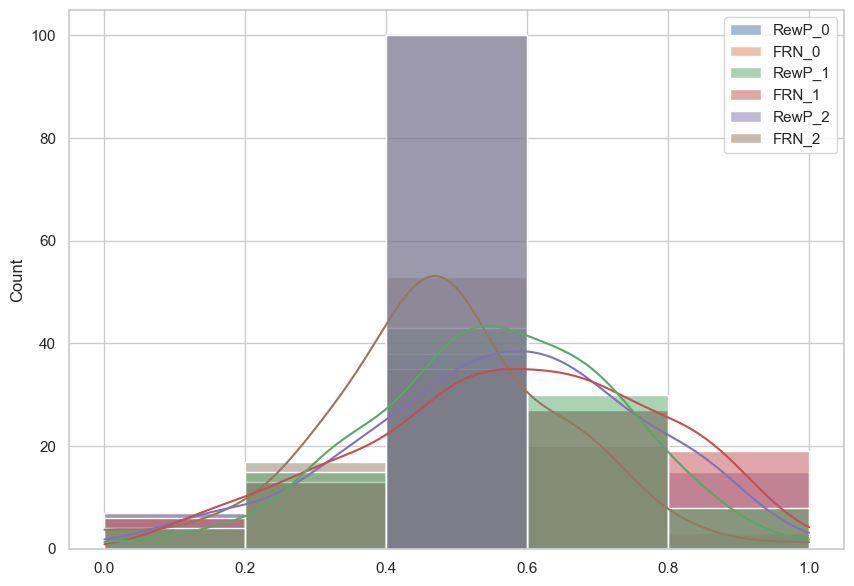

In [144]:
fig = sns.histplot(data=cv_results_df, bins=5, kde=True)

#### Test differences between the best models

Chose the best models

In [145]:
results_anx_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_precision,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy
0,lg,RewP_Anxiety_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,0.500000,0.00000,0.500000
0,svc,RewP_Anxiety_svc,0.681818,0.542857,(SVC(C=1000)),"{'svc__C': 1000, 'svc__kernel': 'rbf'}",0.319680,0.653061,0.785714,0.285714,0.452381,0.761905,0.517576,0.587755,0.62381,0.542857
0,lda,RewP_Anxiety_lda,0.575758,0.583333,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.128871,0.387755,0.809524,0.476190,0.642857,0.642857,0.625000,0.591837,0.52381,0.583333


In [146]:
results_anx_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_precision,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy
0,lg,FRN_Anxiety_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,0.500000,0.000000,0.500000
0,svc,FRN_Anxiety_svc,0.651515,0.542857,(SVC(C=10)),"{'svc__C': 10, 'svc__kernel': 'rbf'}",0.227772,0.204082,0.690476,0.690476,0.547619,0.571429,0.543810,0.540816,0.509524,0.542857
0,lda,FRN_Anxiety_lda,0.469697,0.457143,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.742258,0.775510,0.452381,0.476190,0.309524,0.619048,0.488333,0.526531,0.361905,0.457143


In [147]:
anx_rewp_model = results_anx_rewp_df.iloc[1].best_model
anx_rewp_model

Pipeline(steps=[('svc', SVC(C=1000))])

In [148]:
anx_frn_model = results_anx_frn_df.iloc[1].best_model
anx_frn_model

Pipeline(steps=[('svc', SVC(C=10))])

- Balanced Accuracy

In [149]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='balanced_accuracy'
)

In [150]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.236
p value: 0.407


- Roc AUC

In [151]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='roc_auc'
)

In [152]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.167
p value: 0.434


- precision

In [153]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='precision'
)

In [154]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.337
p value: 0.368


- recall

In [155]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='recall'
)

In [156]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.359
p value: 0.360


- F1

In [157]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='f1'
)

In [158]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.011
p value: 0.496


Visualize difference between FRN and RewP models

In [159]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(anx_rewp_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
cv_scores_2 = cross_val_score(anx_frn_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')

In [160]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

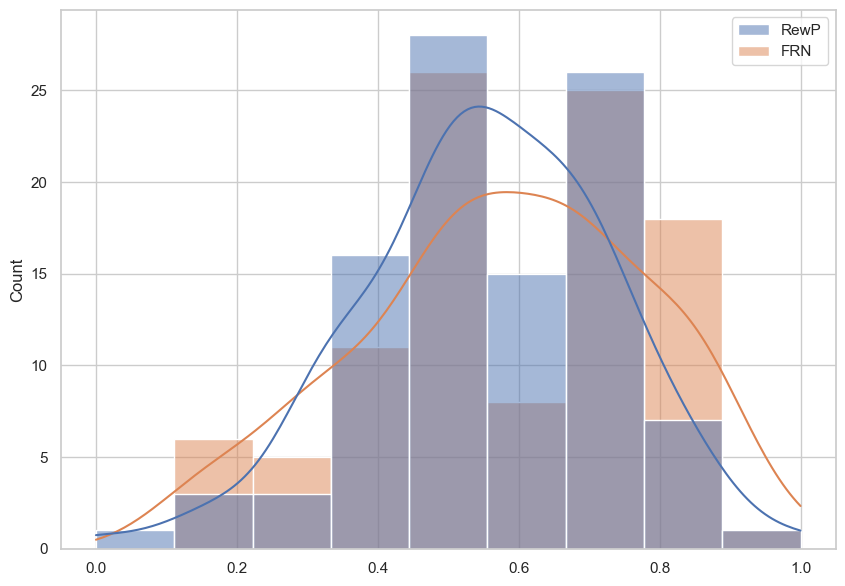

In [161]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

In [162]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(anx_rewp_model, X_rewp, y, cv=cv, scoring='roc_auc')
cv_scores_2 = cross_val_score(anx_frn_model, X_frn, y, cv=cv,  scoring='roc_auc')

In [163]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

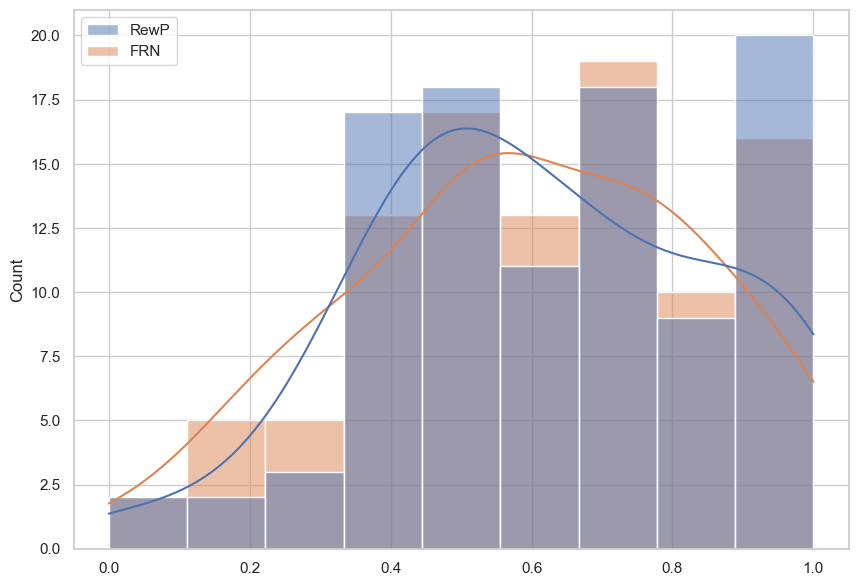

In [164]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)